In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from matplotlib import pyplot as plt
import requests, json
import numpy as np
# from scipy.signal import medfilt2d
import sys
import os
sys.path.append('/Users/bpb/Data/programming/OpenMSI/openmsi-programmatic-access/')
import openmsi


In [5]:
client = requests.Session()
client = openmsi.authenticateUser(client,'username')

········


In [8]:
# files = openmsi.getFilelist(client)
# for f in files:
#     print f

In [9]:
myFile = '/project/projectdirs/openmsi/omsi_data_private/katezh/20150424_KZH_TLW_Rhizosphere_Sidecar_2.h5'

(374, 296, 108743)


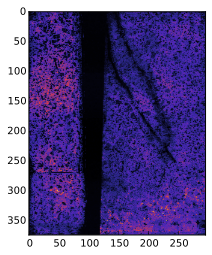

In [22]:
# myIons = [1241.25, 917.5, 817.6]
myIons = [1042.0, 910.0]
myRange = 2 # integrate at +/- this amount
# filename = '/project/projectdirs/openmsi/omsi_data_private/bpb/20120913_nimzyme.h5'
import ast
dataIndex = '0'
expIndex = '0'
payload = {'file':myFile,'format':'JSON','mtype':'file','expIndex':expIndex,'dataIndex':dataIndex}
url = 'https://openmsi.nersc.gov/openmsi/qmetadata'
r = client.get(url,params=payload)
metadata = json.loads(r.content)
originalSize = ast.literal_eval(metadata[u'children'][0][u'shape'])
print originalSize


mz = openmsi.getMZ(client,myFile,expIndex,dataIndex)
imStack = np.zeros((originalSize[0],originalSize[1],len(myIons)))
for i,ion in enumerate(myIons):
    idx = np.where(abs(mz-ion)<myRange)
    payload = {'file':myFile,
               'expIndex':expIndex,'dataIndex':dataIndex,'format':'JSON','mz':'%d:%d'%(min(idx[0]),max(idx[0]))}
    url = 'https://openmsi.nersc.gov/openmsi/qcube'
    r = client.get(url,params=payload)
    data = np.asarray(json.loads(r.content))
#     imStack[:,:,i] = np.sum(data,2)
    imStack[:,:,i] = np.max(data,2)

baseImage = np.sum(imStack,2)
plt.imshow(baseImage,cmap='CMRmap')
plt.show()

In [29]:
R = np.zeros((originalSize[0],originalSize[1]))
Ip = imStack[:,:,0]
Is = imStack[:,:,1]
#Save images
import matplotlib
matplotlib.image.imsave('productImage.png', Ip)
matplotlib.image.imsave('substrateImage.png', Is)


intensityCutoff = 100

for myRow in range(Ip.shape[0]):
    for myCol in range(Ip.shape[1]):
        if Is[myRow,myCol] > intensityCutoff:
            if Ip[myRow,myCol] > intensityCutoff:
                R[myRow,myCol] = Ip[myRow,myCol] / (Is[myRow,myCol] + Ip[myRow,myCol])




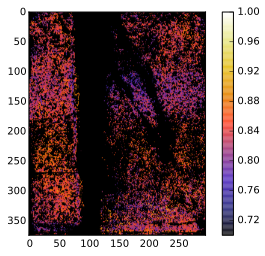

In [30]:

plt.imshow(R,cmap='CMRmap',vmin=0.7, vmax=1)
plt.colorbar()
plt.show()
